In [1]:
from pynq import Overlay
from pynq import allocate
from pynq import MMIO
import numpy as np
from time import time
from tqdm import tqdm

In [2]:
# Prepare the custome overlay and DMA
ol = Overlay("/home/xilinx/classifier.bit")
ol.download()

dma_mm2s = ol.axi_dma_0
dma_s2mm = ol.axi_dma_1

# Accelerator Base Address
ACCEL_CTRL = 0x43C00000

# Initialize HLS IP
mmult_ip = MMIO(ACCEL_CTRL, 0x10000)

# Start the accelerator
ctrl = mmult_ip.read(0x00) & 0x08
mmult_ip.write(0x00, (ctrl | 0x81))
ctrl = mmult_ip.read(0x00)
hex(ctrl)

'0x81'

In [3]:
# Classifier Dimensions
BATCH = 2048
FEAT = 256
CLASSES = 10

# Initialize offsets, weights and inputs
o = np.load("model_offsets.npy").astype(np.float32)
w = np.load("model_weights.npy").astype(np.float32)
i = np.load("test_data.npy").astype(np.float32)
l = np.load("test_labels.npy").astype(np.float32)

# Sample BATCHSIZE test samples from the MNIST test dataset
np.random.seed(0xCAFEBEEF)
ridx = np.random.choice(np.arange(len(i)), BATCH, replace=False)
i = i[ridx]
l = l[ridx]

In [4]:
# Move offset, weight and input data to DMA buffer
input_buffer = allocate(
    shape=(CLASSES + CLASSES * FEAT + BATCH * FEAT,), dtype=np.float32
)
output_buffer = allocate(shape=(BATCH * CLASSES,), dtype=np.float32)

input_buffer[:] = [*o, *w.flatten(), *i.flatten()]
input_buffer.flush()


def fpga_test():
    # Perform FPGA offloading
    start_t = time()
    dma_mm2s.sendchannel.transfer(input_buffer)
    dma_s2mm.recvchannel.transfer(output_buffer)
    dma_mm2s.sendchannel.wait()
    dma_s2mm.recvchannel.wait()
    fpga_time = time() - start_t

    # Dump FPGA result to a numpy array
    c = np.reshape(np.array(output_buffer), (BATCH, CLASSES))
    return c, fpga_time

In [5]:
# Prepare input and weight matrices for matrix multiplication on CPU
ones = np.ones(BATCH).reshape((BATCH, 1))
i_p = np.append(ones, i, axis=1)
w_p = np.append(o.reshape(CLASSES, 1), w, axis=1)


def cpu_test():
    # Compute CPU result
    start_t = time()
    c_ref = np.dot(i_p, w_p.T)
    cpu_time = time() - start_t
    return c_ref, cpu_time

In [6]:
fpga_perf = []
cpu_perf = []

for _ in tqdm(range(32)):
    c, fpga_time = fpga_test()
    c_ref, cpu_time = cpu_test()
    fpga_perf.append(fpga_time)
    cpu_perf.append(cpu_time)

fpga_perf = np.array(fpga_perf) * 1000
cpu_perf = np.array(cpu_perf) * 1000
fpga_time = fpga_perf.mean()
cpu_time = cpu_perf.mean()

100%|██████████| 32/32 [00:03<00:00, 10.24it/s]


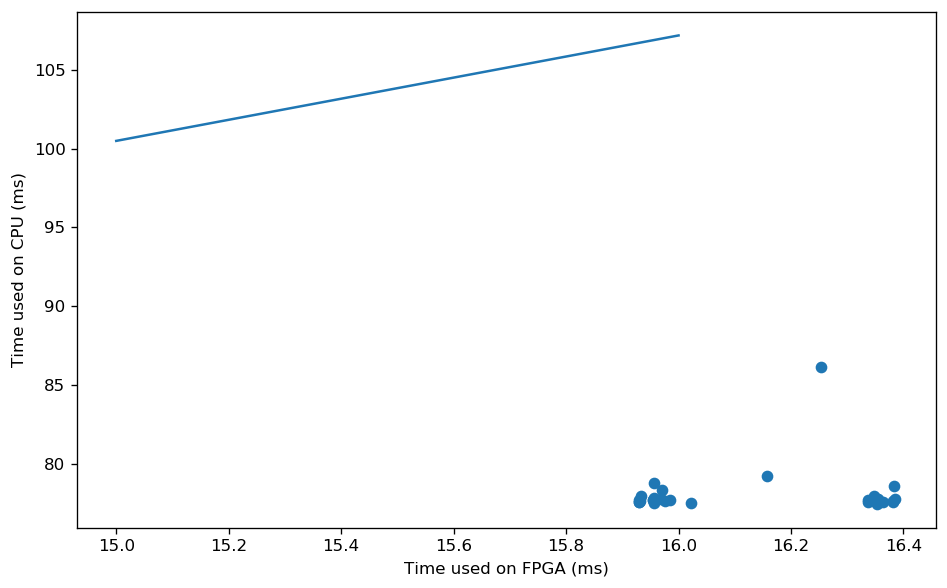

In [7]:
def stat():
    from matplotlib import pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
    ax.scatter(fpga_perf, cpu_perf)
    ax.set_xlabel("Time used on FPGA (ms)")
    ax.set_ylabel("Time used on CPU (ms)")

    x = np.linspace(int(fpga_perf.min()), int(fpga_perf.max() + 0.5), 2)
    ax.plot(x, 6.7 * x)

    return fig


fig = stat()
fig.tight_layout()

In [8]:
# Evaluate validation accuracy
cpu_errors = 0
fpga_errors = 0
for idx in range(BATCH):
    fpga_label = np.argmax(c[idx])
    cpu_label = np.argmax(c_ref[idx])
    actual_label = np.argmax(l[idx])
    if fpga_label != actual_label:
        fpga_errors += 1.0
    if cpu_label != actual_label:
        cpu_errors += 1.0

# Report results
print("FPGA accuracy: {:.2f}% validation error".format(fpga_errors / BATCH * 100))
print("CPU  accuracy: {:.2f}% validation error".format(cpu_errors / BATCH * 100))
if cpu_time < fpga_time:
    print("FPGA has a {0:.2f}x slowdown".format(fpga_time / cpu_time))
else:
    print("FPGA has a {0:.2f}x speedup".format(cpu_time / fpga_time))

FPGA accuracy: 13.04% validation error
CPU  accuracy: 13.04% validation error
FPGA has a 4.83x speedup


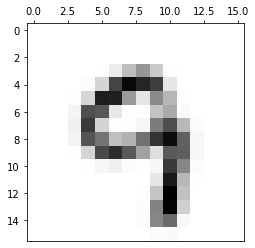

Classified as 9 by the FPGA


In [9]:
# Render a given numpy 2D array of pixel data.
def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl

    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation("nearest")
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_ticks_position("left")
    pyplot.show()


# Inspect one of the hand digits classified by the FPGA
idx = 1
show(i[idx].reshape(16, 16))
print("Classified as {} by the FPGA".format(np.argmax(c[idx])))